In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [5]:
!ls drive/bowl/models

albunet_resize.pth		 starterkit2.pth
albustarterkit_albunet.pth	 starterkit_albunet.pth
cool_model_which_can_work.torch  starterkit.pth
starterkit2cc2.pth		 starter_starterkit_albunet.pth
starterkit2cc.pth		 starterstarterkit_albunet.pth


In [6]:
!ls

datalab  drive


In [0]:
!mkdir bowl/

In [0]:
!mkdir bowl/stage1_train/

In [0]:
!mkdir bowl/stage1_test/

In [0]:
!mkdir bowl/stage2_test/

In [0]:
!unzip drive/bowl/stage1_train.zip -d bowl/stage1_train/

In [0]:
!unzip drive/bowl/stage1_test.zip -d bowl/stage1_test/

In [0]:
!unzip drive/bowl/stage2_test_final.zip -d bowl/stage2_test/

In [0]:
!cp drive/bowl/stage1_solution.csv stage1_solution.csv

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
import pandas as pd
import numpy as np

import cv2
import os

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

import matplotlib.pyplot as plt
import matplotlib.cm as cm  

from skimage.morphology import label

%matplotlib inline

In [0]:
from torchvision import transforms, utils
from skimage import io, transform

In [0]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

def iou_t(target, pred):
  target_y = label(target > 0.5)
  pred_y = label(pred > 0.5)
  true_objs = len(np.unique(target_y))
  pred_objs = len(np.unique(pred_y))
  intersection = np.histogram2d(target_y.flatten(),
                                pred_y.flatten(),
                                bins=(true_objs, pred_objs))[0]
  
  area_true = np.histogram(target_y, bins = true_objs)[0]
  area_pred = np.histogram(pred_y, bins = pred_objs)[0]
  area_true = np.expand_dims(area_true, -1)
  area_pred = np.expand_dims(area_pred, 0)
  
  union = area_true + area_pred - intersection
  
  intersection = intersection[1:,1:]
  union = union[1:,1:]
  union[union == 0] = 1e-9

  iou = intersection / union
  
  prec = []
  for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    prec.append(p)
  return np.mean(prec)

In [0]:
class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

In [0]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

In [0]:
class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


In [0]:
class AlbuNet1(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder
        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=True, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        #print("input size: ", x.size())
        conv1 = self.conv1(x)
        #print("conv1 size: ", conv1.size())
        conv2 = self.conv2(conv1)
        #print("conv2 size: ", conv2.size())
        conv3 = self.conv3(conv2)
        #print("conv3 size: ", conv3.size())
        conv4 = self.conv4(conv3)
        #print("conv4 size: ", conv4.size())
        conv5 = self.conv5(conv4)
        #print("conv5 size: ", conv5.size())

        center = self.center(self.pool(conv5))
        #print("center size: ", center.size())

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        #print("dec5 size: ", dec5.size())

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.sigmoid(self.final(dec0))
        else:
            x_out = self.final(dec0)

        return x_out

In [0]:
class LossBinary:
    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [0]:
class DanillTransform:
    def __init__(self, trans, prob=1., instruction=(True, True, False, False)):
        self.trans = trans
        self.prob = prob
        self.x_in, self.mask_in, self.center_in, self.bound_in = instruction

    def __call__(self, x, mask, center, bound):

        if True:
            if self.x_in:
                x = self.trans(x)
            if self.mask_in:
                mask = self.trans(mask)
            if self.center_in:
                center = self.trans(center)
            if self.bound_in:
                bound = self.trans(bound)
        return x, mask, center, bound

In [0]:
class UnetTansformation:
    def __init__(self, prob=.5):
        self.prob = prob

    def __call__(self, img):
        shape = img.shape

        if (shape[0] % 64 == 0) and (shape[1] % 64 == 0):
            return img

        indention_0 = 64 - shape[0] % 64
        indention_1 = 64 - shape[1] % 64

        indented_img = np.zeros((shape[0] + indention_0, shape[1] + indention_1, shape[2])).astype(np.uint8)
        indented_img[indention_0 // 2:-(indention_0 - indention_0 // 2), indention_1 // 2:-(indention_1 - indention_1 // 2), :] = img
        return indented_img

      
def back_shaper(img,shape:tuple):
        if (shape[0] % 64 == 0) and (shape[1] % 64 == 0):
            return img

        indention_0 = 64 - shape[0] % 64
        indention_1 = 64 - shape[1] % 64
        
        return img[indention_0 // 2:-(indention_0 - indention_0 // 2), indention_1 // 2:-(indention_1 - indention_1 // 2)]
      
      
      
def unet_deconstructor(dataset, tensor, dirr = '../data/stage1_train/'):
    shapes = []
    dec_images = []
    
    for ids in dataset.img_id:
        img_dir = os.path.join(dirr, ids, 'images',ids + '.png')
        shapes.append(cv2.imread(img_dir).shape)
        
    for i in range(len(dataset)):
        dec_images.append(back_shaper(tensor[i].permute(1,2,0).numpy(),shapes[i]))
    
    return dec_images

In [0]:
class DatasetV2():
    def __init__(self, root_dir, img_id, transform=None, train=True):
        self.root_dir = root_dir
        self.img_id = img_id
        self.transform = transform
        self.train = train
        self.images = [os.path.join(root_dir, train_id, 'images', train_id + '.png') for train_id in img_id]
        if train:
            self.train_masks = {train_id: [os.path.join(root_dir, train_id, 'masks', img_name) for img_name in os.listdir(os.path.join(root_dir, train_id, 'masks'))] for train_id in img_id}
    
    def __getitem__(self, idx):
        if self.train:
            img_dir = os.path.join(self.root_dir, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            print(img_dir)
            img = cv2.imread(img_dir)
            masks = [cv2.imread(train_mask)[..., 0] for train_mask in self.train_masks[self.img_id[idx]]]
            mask = sum(masks) #FOR STAS: Here is a mask reading and center+contour extraction
            centers = []
            for m in masks:
                centers.append(get_center(m))#works only for single mask file(not for the sum of masks)
            mask_center = sum(centers)
            mask_contour = get_contour(mask) #works for sum of masks(but may be better for single mask file, need tests)
            
            mask_contour = np.expand_dims(mask_contour, -1)
            mask_center = np.expand_dims(mask_center, -1)
            mask = np.expand_dims(mask, -1)
            
            mask[mask > 0.00001] = 255
            print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            img, mask, mask_center, mask_contour = self.transform(img, mask, mask_center, mask_contour)
            img[:,:,0], img[:,:,2] = img[:,:,2], img[:,:,0] #return_to_RGB
            print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            
            
            mask = np.swapaxes(mask, 2, 0) / 255.0
            img = np.swapaxes(img, 2, 0) / 255.0
            mask_contour = np.swapaxes(mask_contour, 2, 0) / 255.0
            mask_center = np.swapaxes(mask_center, 2, 0) / 255.0
            
            print(img.shape, mask.shape, mask_center.shape, mask_contour.shape)
            
            
            sample = torch.FloatTensor(np.stack((img[0], img[1], img[2], mask[0], mask_center[0], mask_contour[0])))
            
          
        else:
            img_dir = os.path.join(self.root_dir, self.img_id[idx], 'images', self.img_id[idx] + '.png')
            img = cv2.imread(img_dir)
            h = img.shape[0]
            w = img.shape[1]
            #print(shape)
            img = self.transform(img)
            img = np.expand_dims(img, 0)
            img = np.swapaxes(img, -1, 0) / 255.0
            img = np.squeeze(img)
            #print(img.shape)
            sample = torch.FloatTensor(img), self.img_id[idx], h, w # probably big crutch
        return sample
        
    def __len__(self):
        return len(self.img_id)

In [0]:
def rleToMask(rleString,height,width):
  rows,cols = height,width
  rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
  rlePairs = np.array(rleNumbers).reshape(-1,2)
  img = np.zeros(rows*cols,dtype=np.uint8)
  for index,length in rlePairs:
    index -= 1
    img[index:index+length] = 255
  img = img.reshape(cols,rows)
  img = img.T
  return img

In [0]:
df = pd.read_csv('stage1_solution.csv')
for img_id in test1_ids:
    path = os.path.join(TEST1_DIR, img_id)
    try:
        os.mkdir(os.path.join(path, 'masks/'))
    except Exception as e:
        print(e)
    img = cv2.imread(os.path.join(path, 'images', img_id + '.png'))
    h, w = img.shape[:2]
    masks = [rleToMask(rle, h, w) for rle in df[df.ImageId == img_id].EncodedPixels]
    i = 0
    for mask in masks:
      print(img_id, i)
      cv2.imwrite(os.path.join(path, 'masks', str(i) + '.png'), mask)
      i += 1
      
    

In [108]:
data = DatasetV2(TEST1_DIR, test1_ids, transform=train_transform)
print(data[0].size())

bowl/stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/images/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f.png
(256, 256, 3) (256, 256, 1) (256, 256, 1) (256, 256, 1)
(256, 256, 3) (256, 256, 1) (256, 256, 1) (256, 256, 1)
(3, 256, 256) (1, 256, 256) (1, 256, 256) (1, 256, 256)
torch.Size([6, 256, 256])


In [0]:
!tar -cvf stage1_test_train.zip bowl/stage1_test/

In [0]:
!cp stage1_test_train.zip drive/bowl/stage1_test_train.zip

In [0]:
model_path = "drive/bowl/models/"
submission_path = "drive/bowl/submissions/"
model_name = "albunet_resize"
model_file = model_name + '.pth'
submission_file = model_name + '.csv'

In [0]:
TRAIN_DIR = 'bowl/stage1_train/'

train_ids = os.listdir(TRAIN_DIR)
train_images = [os.path.join(TRAIN_DIR, train_id, 'images', train_id + '.png') 
                for train_id in train_ids]
train_masks = {train_id: [os.path.join(TRAIN_DIR, train_id, 'masks', img_name) 
                          for img_name in os.listdir(os.path.join(TRAIN_DIR, train_id, 'masks'))]
               for train_id in train_ids}

In [0]:
TEST_DIR = 'bowl/stage2_test/'
test_ids = os.listdir(TEST_DIR)
test_images = [os.path.join(TEST_DIR, test_id, 'images', test_id + '.png') 
                for test_id in test_ids]

In [0]:
TEST1_DIR = 'bowl/stage1_test/'
test1_ids = os.listdir(TEST1_DIR)
test1_images = [os.path.join(TEST1_DIR, test_id, 'images', test_id + '.png') 
                for test_id in test1_ids]

In [0]:
from scipy import ndimage as ndi
def get_contour(img):
    img_contour = np.zeros_like(img)
    _, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    cv2.drawContours(img_contour, contours, -1, (255, 255, 255), 2)
    return img_contour
  
def get_center(img):
    img_center = np.zeros_like(img)
    y, x = ndi.measurements.center_of_mass(img)
    cv2.circle(img_center, (int(x), int(y)), 4, (255, 255, 255), -1)
    return img_center

In [0]:
starter_model = nn.Sequential(nn.Conv2d(3, 16, (11, 11), padding=5),
                      nn.ReLU(),
                      nn.Conv2d(16, 96, (5, 5), padding=2), #extra mid channels to detect more features
                      nn.ReLU(),
                      nn.Conv2d(96, 3, (5, 5), padding=2), #3 out channels : [0] - mask; [1] - center; [2] - border
                      nn.Sigmoid())

In [0]:
def default_loss_composition(loss1, loss2, loss3):
  return loss1 + loss2 + loss3

In [0]:
def train(model, dataset, loss_mask, loss_center, loss_border, loss_compose_fn = default_loss_composition, best_loss_val = 9999, name_prefix="", n_epochs=10, batch_size=16):

  #tp = TelepythClient(token="3105941719605529941")
  #tp.send_text("Training on " + name_prefix + model_name)
  
  N_EPOCHS = n_epochs
  BATCH_SIZE = batch_size
  lr = 0.0004
  optimizer = Adam(model.parameters(), lr=lr)
  model.cuda()
  model.train()
  best_loss = best_loss_val #тут храним лучший лосс среди всех эпох
  losses = []
  for epoch in range(N_EPOCHS): #итерируемся по числу эпох
      report_ep = "Epoch[{}]".format(epoch)
      if epoch % 10 == 9:
        optimizer = Adam(model.parameters(), lr = lr / 5) #каждые десять эпох уменьшаем лернинг рейт(не уверен что это норм способ)
      #tp.send_text(report_ep)
      print("Epoch[{}]".format(epoch))
      b = 0 #храним номер текущего батча(в конце эпохи зануляется)
      i = 0 #хз чо но пусть будет
      losses = [] 
      mean_loss = 999
      optimizer.zero_grad()
      epoch_iou = [] #массив значений iou по эпохе(содержит средние значения по каждому из батчей)
      ious = [] #массив значений iou по батчу
      
      for sample in dataset:
          batch_x = Variable(sample[:3].cuda()).unsqueeze(dim=0) # получаем перве три канала(картинку), оборачиваем в вариэйбл, и расширяем до батч*каналы*высота*ширина

          batch_mask = Variable(sample[3].cuda()) #читаем маску
          
          batch_center = Variable(sample[4].cuda()).squeeze() #читаем центры
          
          batch_border = Variable(sample[5].cuda()).squeeze() #читаем границы
          
          
        
          pred = model(batch_x)[0] #предиктим и берем первый элемент из батча предиктов(размер батча 1)
          

          loss_1 = loss_mask(pred[0].cpu(), batch_mask.cpu()) #считаем лосс по маскам
          loss_2 = loss_center(pred[1].cpu(), batch_center.cpu()) #считаем лосс по центрам
          loss_3 = loss_border(pred[2].cpu(), batch_border.cpu()) #считаем лосс по границам
          loss = loss_compose_fn(loss_1, loss_2, loss_3) #композитим три лосса
          losses.append(loss[0].data.cpu().numpy())
          loss = loss / BATCH_SIZE #хз чо но работает
          loss.backward() #градиенты
          iou = iou_t(batch_mask.data.cpu().numpy(), pred[0].data.cpu().numpy()) #считаем iou для конкретного изображения
        
          
          losses.append(loss)# добавляем в историю лоссов
          ious.append(iou)# добавлчем список значений по батчу
        
          if i % BATCH_SIZE == BATCH_SIZE - 1:#если подошли к концу батча
            
              mean_loss = np.array(losses).mean()[0].data.cpu().numpy()
              losses = []
              mean_iou = np.array(ious).mean() #считаем средний по батчу
              epoch_iou.append(mean_iou) #добавляем в список средних по эпохе
              ious = [] #зануляем список средних по батчу
              
              report_b = "Batch #{}; Loss:{}; Mean IoU:{}".format(b, mean_loss, mean_iou)
              #if b % 20 == 0:
                #tp.send_text(report_b)
              print(report_b)
              b += 1
              optimizer.step() #Оптимайзим
              i = -1
              optimizer.zero_grad() #Зануляемся
          i += 1
      if (mean_loss < best_loss): #Сохраняем модель если лосс улучшился
        iou = np.array(epoch_iou).mean()
        best_loss = mean_loss
        report_loss = "Epoch loss - {}. Epoch IoU - {}. Loss improved; Model Saved as {}".format(mean_loss, iou, model_path + name_prefix + model_file)
        torch.save(model,  model_path + name_prefix + model_file)
        #tp.send_text(report_loss)
        print(report_loss)
        
      else: #Или не сохраняем, если не
        report_loss = "Epoch last loss - {}. Not an improvement".format(mean_loss)
        #tp.send_text(report_loss)
        print(report_loss)
        
  report_end = "Training ended"
  print(report_end)
  #tp.send_text(report_end)
  return losses

In [0]:
def valid(model, data, loss_compose_fn = default_loss_composition, loss_mask=F.binary_cross_entropy, loss_center=F.binary_cross_entropy, loss_border=F.binary_cross_entropy):
  model.cuda()
  model.eval()
  ious = []
  losses = []
  for sample in data:
    x = Variable(sample[:3].cuda()).unsqueeze(dim=0)
    y_mask = Variable(sample[3]).cuda()
    y_center = Variable(sample[4]).cuda()
    y_border = Variable(sample[5]).cuda()
    
    pred = model(x)[0]
    
    loss_1 = loss_mask(pred[0], y_mask)
    loss_2 = loss_center(pred[1], y_center)
    loss_3 = loss_border(pred[2], y_border)
    loss = loss_compose_fn(loss_1, loss_2, loss_3)
    
    
    iou = iou_t(y_mask.cpu().data.squeeze().numpy(), pred[0].data.squeeze().cpu().numpy())
    
    losses.append(loss.cpu().data.numpy())
    ious.append(iou)
    
  val_loss = np.array(losses).mean()
  val_iou = np.array(ious).mean()
  
  return val_loss, val_iou

In [0]:
class DanillCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, mask, center, bound):
        for t in self.transforms:
            x, mask, center, bound = t(x, mask, center, bound)
        return x, mask, center, bound
      
class Reshape4:
    def __init__(self, prob=.5):
        self.prob = prob

    def __call__(self, img, mask, center, bound):
        shape = mask.shape
        return img, mask.reshape(shape[0], shape[1], 1), center.reshape(shape[0], shape[1], 1), bound.reshape(shape[0],
                                                                                                              shape[1],
                                                                                                              1)


train_transform = DanillCompose([
        DanillTransform(UnetTansformation(),instruction=(True, True, True, True)),
        #RandomCrop4(),
        #ShiftScaleRotate4(),
        #HorizontalFlip4(),
        #VerticalFlip4(),
        #DanillTransform(RandomHueSaturationValue(), instruction=(True, False, False, False)),
        #DanillTransform(RandomBrightness(), instruction=(True, False, False, False)),
        #DanillTransform(RandomContrast(), instruction=(True, False, False, False)),
        #DanillTransform(Normalize(),instruction=(True, False, False, False),prob=0.5),
    ])

In [0]:
train_dataset = DatasetV2(TRAIN_DIR, train_ids[:600], transform=train_transform)

In [28]:
!wget https://raw.githubusercontent.com/stas6626/bowl/master/models.py?token=AE6mj73zduqFnt4n7wK0F3tfUwspODpEks5a2EbqwA%3D%3D

--2018-04-14 19:54:07--  https://raw.githubusercontent.com/stas6626/bowl/master/models.py?token=AE6mj73zduqFnt4n7wK0F3tfUwspODpEks5a2EbqwA%3D%3D
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11023 (11K) [text/plain]
Saving to: ‘models.py?token=AE6mj73zduqFnt4n7wK0F3tfUwspODpEks5a2EbqwA%3D%3D’

models.py?token=AE6 100%[===================>]  10.76K  --.-KB/s    in 0s      

2018-04-14 19:54:07 (50.2 MB/s) - ‘models.py?token=AE6mj73zduqFnt4n7wK0F3tfUwspODpEks5a2EbqwA%3D%3D’ saved [11023/11023]



In [0]:
!mv models.py\?token\=AE6mj73zduqFnt4n7wK0F3tfUwspODpEks5a2EbqwA%3D%3D models.py

In [30]:
!wget https://raw.githubusercontent.com/stas6626/bowl/master/transforms.py?token=AE6mj1k_DMIuXgu9NbnHygt7irzYlGVJks5a2MD0wA%3D%3D

--2018-04-14 19:54:14--  https://raw.githubusercontent.com/stas6626/bowl/master/transforms.py?token=AE6mj1k_DMIuXgu9NbnHygt7irzYlGVJks5a2MD0wA%3D%3D
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27930 (27K) [text/plain]
Saving to: ‘transforms.py?token=AE6mj1k_DMIuXgu9NbnHygt7irzYlGVJks5a2MD0wA%3D%3D’

transforms.py?token 100%[===================>]  27.28K  --.-KB/s    in 0.008s  

2018-04-14 19:54:14 (3.17 MB/s) - ‘transforms.py?token=AE6mj1k_DMIuXgu9NbnHygt7irzYlGVJks5a2MD0wA%3D%3D’ saved [27930/27930]



In [0]:
!mv transforms.py\?token\=AE6mj1k_DMIuXgu9NbnHygt7irzYlGVJks5a2MD0wA%3D%3D transforms.py

In [32]:
albunet = torch.load(model_path + 'cool_model_which_can_work.torch')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torc

In [0]:
albunet = AlbuNet1(pretrained=True, num_classes=3)

In [0]:
losses = train(albunet, train_dataset, best_loss_val=999, n_epochs=100, loss_mask=F.binary_cross_entropy, loss_center=LossBinary(0.01), loss_border=LossBinary(0.01), batch_size=32)

In [46]:
#starter_model = torch.load(model_path + model_file)
valid_dataset = DatasetV2(TRAIN_DIR, train_ids[600:], transform=train_transform)
print(valid(albunet, valid_dataset, loss_mask=LossBinary(), loss_center=LossBinary(), loss_border=LossBinary()))

(0.23818564, 0.35481761772880926)


In [0]:
loss = np.array(losses)

In [0]:
plt.plot(loss)

In [0]:
test_dataset = DatasetV2(TEST_DIR, test_ids, train=False, transform=UnetTansformation())

In [106]:
test_dataset[1122][0].size()

torch.Size([3, 576, 704])

In [0]:
albunet.eval()
albunet.cuda()

In [0]:
def binarize(img : torch.FloatTensor, cutoff = 0.41):
  cutoff_value = img.max() - (cutoff * abs((img.max() - img.min())))
  img = (img < cutoff_value)
  return img

In [0]:
def binarize_minmax(img : torch.FloatTensor, cutoff = 0.5):
  img_p =  1 - ((img - img.min()) / img.max())
  return img_p < cutoff

In [0]:
def imshow_tensor(img: torch.FloatTensor, grayscale = False, title="Img"):
  plt.figure()
  plt.title(title)
  if grayscale:
    plt.imshow(img.squeeze().numpy())
  else:
    plt.imshow(img.permute(1, 2, 0).numpy())

(520, 694, 3)
520 694
<built-in method size of torch.FloatTensor object at 0x7f2e6bd8fd88>
Variable containing:
-12.1980
[torch.FloatTensor of size 1]
 Variable containing:
 6.2829
[torch.FloatTensor of size 1]



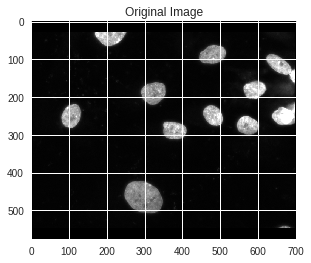

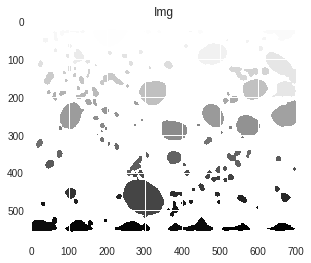

In [107]:
sample, name, h, w = test_dataset[1122]
print(cv2.imread(os.path.join(TEST_DIR, name, 'images', name + '.png')).shape)
print(h, w)
print(sample.size)
imshow_tensor(sample, title='Original Image')
#sample_mask = sample[3]
#imshow_tensor(sample_mask, True, 'Mask')
pred = albunet(Variable(sample).cuda().unsqueeze(dim=0)).squeeze().cpu()
imshow_tensor(torch.FloatTensor(label(watershed_v3(pred[0].data.numpy(), pred[2].data.numpy()))), True)
print(pred[0].min(), pred[0].max())

In [0]:


def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x):
    lab_img = label(x)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [38]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 3.1MB/s 


In [65]:
x, name, h, w = test_dataset[540]
img = cv2.imread(os.path.join(TEST_DIR, name, 'images', name + '.png'))
print(img.shape)
print(h, w)

(304, 560, 3)
304 560


In [0]:
from tqdm import *

In [0]:
from skimage.transform import resize
image_ids = []
rles = []
predicts = []
#starternet.cpu()
#albunet.cpu()
#starternet.eval()
#albunet.eval()
albunet.cuda()

for i in tqdm(range(0, len(test_dataset))):
    test, name, h, w = test_dataset[i]
    #test_h = test[2]
    #test_w = test[3]
    
    #print(h, w)
    #print(test.size())
    
    batch_x = torch.unsqueeze(test, dim=0)
    batch_x = Variable(batch_x).cuda()
    
    
    pred_i = albunet(batch_x).squeeze().data.cpu().numpy()
    
    mask = back_shaper(pred_i[0], (h, w))
    #pred_i[1] = back_shaper(pred_i[1], (w, h))
    #contour = back_shaper(pred_i[2], (h, w))
    
    #pred_i = binarize_minmax(pred_i)
    
    #water_predict = binarize(watershed_v3(mask, contour), cutoff=1.0)
    
    
    #pred_i = np.expand_dims(pred_i, -1)
    #pred_i = np.swapaxes(pred_i, 0, -1)
    #pred_i = np.squeeze(pred_i)
    
    current_rles = [rle for rle in prob_to_rles(binarize(mask))]
    
    if len(current_rles) != 0:
        for rle in current_rles:
            image_ids.append(name)
            rles.append(rle)
    else:
        image_ids.append(name)
        rles.append([])
    #print(name, len(rles))

 31%|███       | 936/3019 [03:17<07:20,  4.73it/s]

In [0]:
import pandas as pd
submission = pd.DataFrame(data={'ImageId': image_ids,
                                'EncodedPixels': [' '.join(map(str, x)) for x in rles]})

In [45]:
submission.head(1)

,EncodedPixels,ImageId
0,1 6 257 5 513 5 769 5 1025 5 1281 4 1537 2,bc9ee507f0b0d0f68f49ee72cbf1a1275465d0b7a99136...


In [46]:
len(submission['ImageId'].drop_duplicates())

3019

In [0]:
submission.to_csv('submit1.csv', index=None)

In [48]:
!tar -cvf submit1.csv.zip submit1.csv

submit1.csv


In [92]:
!ls

bowl	 drive	    __pycache__		 submit.csv	 transforms.py
datalab  models.py  stage1_solution.csv  submit.csv.zip


In [0]:
!cp submit1.csv.zip drive/bowl/submissions/submit1.csv.zip

In [0]:
submission.to_csv(submission_path + '1'+submission_file, index=None)

0 11


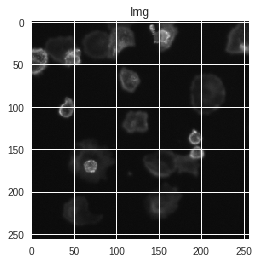

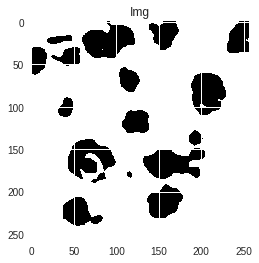

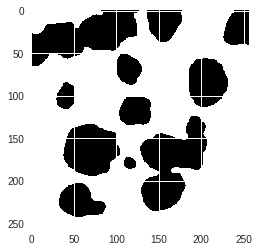

In [80]:
sample = test_dataset[1344]
img = sample[0]
imshow_tensor(img)
pred = albunet(Variable(img).cuda().unsqueeze(dim=0)).squeeze()
imshow_tensor(binarize(pred.cpu().data[0]), grayscale=True)
x = watershed_v3(pred[0].cpu().data.numpy(), pred[2].cpu().data.numpy())
print(x.min(), x.max())
plt.figure()
plt.imshow(x>0.1)

In [0]:
#WATERSHED

In [0]:
from itertools import product
import skimage.morphology as morph
from skimage.filters import threshold_otsu
import scipy.ndimage as ndi
from scipy.stats import itemfreq

def drop_artifacts(mask_after, mask_pre, min_coverage=0.5):
    connected, nr_connected = ndi.label(mask_after)
    mask = np.zeros_like(mask_after)
    for i in range(1, nr_connected + 1):
        conn_blob = np.where(connected == i, 1, 0)
        initial_space = np.where(connected == i, mask_pre, 0)
        blob_size = np.sum(conn_blob)
        initial_blob_size = np.sum(initial_space)
        coverage = float(initial_blob_size) / float(blob_size)
        if coverage > min_coverage:
            mask = mask + conn_blob
        else:
            mask = mask + initial_space
    return mask

def pad_mask(mask, pad):
    if pad <= 1:
        pad = 2
    h, w = mask.shape
    h_pad = h + 2 * pad
    w_pad = w + 2 * pad
    mask_padded = np.zeros((h_pad, w_pad))
    mask_padded[pad:pad + h, pad:pad + w] = mask
    mask_padded[pad - 1, :] = 1
    mask_padded[pad + h + 1, :] = 1
    mask_padded[:, pad - 1] = 1
    mask_padded[:, pad + w + 1] = 1

    return mask_padded

def crop_mask(mask, crop):
    if crop <= 1:
        crop = 2
    h, w = mask.shape
    mask_cropped = mask[crop:h - crop, crop:w - crop]
    return mask_cropped

def mean_blob_size(mask):
    labels, labels_nr = ndi.label(mask)
    if labels_nr < 2:
        mean_area = 1
        mean_radius = 1
    else:
        mean_area = int(itemfreq(labels)[1:, 1].mean())
        mean_radius = int(np.round(np.sqrt(mean_area) / np.pi))
    return mean_area, mean_radius

def add_dropped_water_blobs(water, mask_cleaned):
    water_mask = (water > 0).astype(np.uint8)
    dropped = mask_cleaned - water_mask
    dropped, _ = ndi.label(dropped)
    dropped = np.where(dropped, dropped + water.max(), 0)
    water = water + dropped
    return water

def relabel(img):
    h, w = img.shape

    relabel_dict = {}

    for i, k in enumerate(np.unique(img)):
        if k == 0:
            relabel_dict[k] = 0
        else:
            relabel_dict[k] = i
    for i, j in product(range(h), range(w)):
        img[i, j] = relabel_dict[img[i, j]]
    return img

def drop_small(img, min_size):
    img = morph.remove_small_objects(img, min_size=min_size)
    return relabel(img)

def fill_holes_per_blob(image):
    image_cleaned = np.zeros_like(image)
    for i in range(1, image.max() + 1):
        mask = np.where(image == i, 1, 0)
        mask = ndi.morphology.binary_fill_holes(mask)
        image_cleaned = image_cleaned + mask * i
    return image_cleaned

def drop_artifacts_per_label(labels, initial_mask):
    labels_cleaned = np.zeros_like(labels)
    for i in range(1, labels.max() + 1):
        component = np.where(labels == i, 1, 0)
        component_initial_mask = np.where(labels == i, initial_mask, 0)
        component = drop_artifacts(component, component_initial_mask)
        labels_cleaned = labels_cleaned + component * i
    return labels_cleaned

def clean_mask_v2(m,c):
    # threshold
    m_b = m > threshold_otsu(m)
    c_b = c > threshold_otsu(c)

    # combine contours and masks and fill the cells
    m_ = np.where(m_b | c_b, 1, 0)
    m_ = ndi.binary_fill_holes(m_)

    # close what wasn't closed before 
    area, radius = mean_blob_size(m_b)
    struct_size = int(1.25*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(m_, pad=struct_size)
    m_padded = morph.binary_closing(m_padded, selem=struct_el)
    m_ = crop_mask(m_padded, crop=struct_size)
    
    # open to cut the real cells from the artifacts
    area, radius = mean_blob_size(m_b)
    struct_size = int(0.75*radius)
    struct_el = morph.disk(struct_size)
    m_ = np.where(c_b & (~m_b), 0, m_)
    m_padded = pad_mask(m_, pad=struct_size)
    m_padded = morph.binary_opening(m_padded, selem=struct_el)
    m_ = crop_mask(m_padded, crop=struct_size)

    # join the connected cells with what we had at the beginning
    m_ = np.where(m_b|m_,1,0)
    m_ = ndi.binary_fill_holes(m_)
    
    # drop all the cells that weren't present at least in 25% of area in the initial mask 
    m_ = drop_artifacts(m_, m_b,min_coverage=0.25)
    
    return m_

def good_markers_v3(m_b,c):
    # threshold
    c_b = c > threshold_otsu(c)
    
    mk_ = np.where(c_b,0,m_b)
    
    area, radius = mean_blob_size(m_b)
    struct_size = int(0.25*radius)
    struct_el = morph.disk(struct_size)
    m_padded = pad_mask(mk_, pad=struct_size)
    m_padded = morph.erosion(m_padded, selem=struct_el)
    mk_ = crop_mask(m_padded, crop=struct_size)
    mk_,_ = ndi.label(mk_) 
    return mk_

def good_distance_v1(m_b):
    distance = ndi.distance_transform_edt(m_b)
    return distance

In [0]:
def watershed_v3(mask, contour):
    cleaned_mask = clean_mask_v2(mask, contour)
    good_markers = good_markers_v3(cleaned_mask,contour)
    good_distance = good_distance_v1(cleaned_mask)
    
    labels = morph.watershed(-good_distance, good_markers, mask=cleaned_mask)
    
    labels = add_dropped_water_blobs(labels, cleaned_mask)
    
    m_thresh = threshold_otsu(mask)
    initial_mask_binary = (mask > m_thresh).astype(np.uint8)
    labels = drop_artifacts_per_label(labels,initial_mask_binary)
    
    labels = drop_small(labels, min_size=20)
    labels = fill_holes_per_blob(labels)
        
    return labels